## Cats and Dogs (3/3)
### Building powerful image classification models using very little data
By Francois Chollet: 
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Esta é a última parte de três do experimento de *transfer learning*.

Neste experimento, a rede VGG é montada completa, com a parte convolucional e a parte da rede densa treinada no notebook anterior. As camadas finais da parte convolucional é liberada para o treinamento (*fine tuning*).

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import os
import sys
import numpy as np
import numpy.random as nr

import theano
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD, RMSprop

print 'Keras ', keras.__version__
print 'Theano', theano.__version__


Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Keras  1.2.0
Theano 0.8.2


## Dataset

https://www.kaggle.com/c/dogs-vs-cats/data


In [3]:
train_data_dir = '/root/CatsDogs/train'
validation_data_dir = '/root/CatsDogs/validation'
nb_train_samples = 2000
nb_validation_samples = 800

# dimensions of our images.
img_width, img_height = 150, 150

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## VGG Features

[![VGG Network Layers](https://blog.keras.io/img/imgclf/vgg16_modified.png)]()

In [4]:

def load_model_and_history(model_name, loss='binary_crossentropy', opt='adam', metrics=[]):
    import h5py, json
    import cPickle as pickle
    from keras.models import model_from_config
    
    f = h5py.File(model_name + '.model', mode='r')
    model_config = f.attrs.get('model_config')
    model_config = json.loads(model_config.decode('utf-8'))

    untrainable = []
    for ii, lay in enumerate(model_config['config']['layers']):
        if 'trainable' in lay['config'].keys():
            if not lay['config']['trainable']:
                lay['config']['trainable'] = True
                untrainable.append(ii)
            
    model = model_from_config(model_config)
    model.load_weights(model_name + '.model')

    for ii in untrainable:
        model.layers[ii].trainable = False

    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    return model, pickle.load(open(model_name + '.history', 'rb'))


In [ ]:
os.sys.path.append('../src/')
from keras.applications.vgg16 import VGG16
from my_keras_utilities import TrainingPlotter

model_name = '../../models/cats_dogs_vgg_finetune'
top_model_name = '../../models/cats_dogs_vgg.model'

if not os.path.isfile(model_name + '.model'):
    # History, checkpoint, earlystop, loss plotter:
    histo = TrainingPlotter(n=1, filepath=model_name, patience=15)
    
    print("[INFO] creating model...")
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(3, img_height, img_width))
    
    # build a classifier model and put on top of the convolutional model
    x = Flatten()(vgg.output)
    x = Dense(256, activation='relu', name='d1')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid', name='d2')(x)
    
    model = Model(input=vgg.input, output=x)

    print 'Model layers:'
    for i, layer in enumerate(model.layers):
        print '    {:2d} {:15s} {}'.format(i, layer.name, layer)
    
    w1, b1, w2, b2 = load_model(top_model_name).get_weights()
    model.layers[20].set_weights([w1, b1])
    model.layers[22].set_weights([w2, b2])
    
    # set the first 15 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    for layer in model.layers[:15]:
        layer.trainable = False

    print("[INFO] compiling model...")
    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='binary_crossentropy',
                  optimizer=SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])
else:
    print("[INFO] loading model...")
    model, histo = load_model_and_history(model_name, 
                                          loss='binary_crossentropy', 
                                          opt=SGD(lr=1e-4, momentum=0.9), 
                                          metrics=['accuracy'])

model.summary()


[INFO] loading model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 150, 150)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, 150, 150)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, 150, 150)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, 75, 75)    0           block1_conv2[0][0]               
___________________________________________________________________

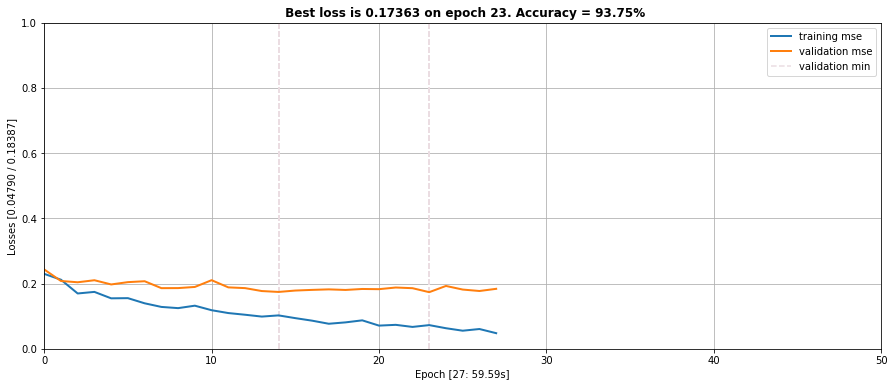

In [ ]:
nb_epoch = 50
ploss = 1.0

nepochs = nb_epoch - histo.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, ploss)
plot.xlim(0, nb_epoch)
plot.grid(True)

if nepochs > 0:
    print("[INFO] training...")
    try:
        # fine-tune the model
        model.fit_generator(
            train_generator,
            samples_per_epoch=nb_train_samples,
            nb_epoch=nb_epoch,
            validation_data=validation_generator,
            nb_val_samples=nb_validation_samples,
            verbose=0,
            callbacks=[histo],
        )
        
    except KeyboardInterrupt:
        pass

else:
    print("[INFO] plotting...")
    # plot history


In [ ]:
print("[INFO] loading model...")
model, histo = load_model_and_history(model_name, loss='binary_crossentropy', 
                                      opt=SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
print("[INFO] evaluating...")
loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))


## Aprendizados com este notebook

